In [1]:
import torch
import numpy as np
from models.training import easyTrainer, weights_to_dataset
from models.nODE import nODE, make_nODE_from_parameters
import matplotlib.pyplot as plt
from itertools import product
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')''

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

adj_list = []
adj_list.append(np.array([[0.,0.],[0.,0.]]))
adj_list.append(np.array([[0,1.],[0,0]]))
adj_list.append(np.array([[0,-1.],[0,0]]))
adj_list.append(np.array([[0,1.],[1.,0]]))
adj_list.append(np.array([[0,1.],[-1.,0]]))
adj_list.append(np.array([[0,-1.],[-1.,0]]))


In [3]:
Nexp = 20
Ndata = 2*[2,4,6,8,10]

def run_fit(adj,ndata):
    ODE_dim = 2
    Gamma = np.array([-1., -1.])
    integration_time = 1
    Win = adj
    Wout = np.array([[2., 0], [0, 2.]])
    bin = np.array([[2.], [2.]])
    bout = np.array([[2.], [2.]])

    train_data, test_data = weights_to_dataset(integration_time, Gamma, Win=Win, bin=bin, Wout=Wout, bout=bout, batch_size = ndata)

    node = nODE(ODE_dim, architecture='both', time_interval=[0, integration_time])

    optimizer_node = torch.optim.Adam(node.parameters(), lr=1e-1)

    trainer = easyTrainer(node, optimizer_node, device, verbose=0)

    trainer.train(train_data, 400)

    return node

def check_node(fitted_node,adj):

    W = fitted_node.outside_weights.weight.matmul(fitted_node.inside_weights.weight)
    values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
    treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
    W_activation = (W >= torch.exp(treshold)).detach().numpy().astype(float)
    W_repr = (W <= -torch.exp(treshold)).detach().numpy().astype(float)
    W = W_activation-W_repr

    if np.all(W == adj):
        return 1
    else:
        return 0
    

corr_list = []
for i in range(0,len(adj_list)):
    corr_list.append([])
    for j in Ndata:
        corr = 0
        for k in range(0,Nexp):
            print('adj_matrix: '+str(i)+', ndata: '+str(j)+', experiment: '+str(k+1))
            fitted_node = run_fit(adj_list[i],j)

            corr = corr + 1/Nexp * check_node(fitted_node,adj_list[i])
        
        corr_list[i].append(corr)
    


adj_matrix: 0, ndata: 2, experiment: 1


ValueError: test_size=0.0 should be either positive and smaller than the number of samples 2 or a float in the (0, 1) range

In [ ]:
print(corr_list)

[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.5, 0.0], [0.0, 0.0], [0.0, 0.0]]


Plot phase portrait based on current nODE parameters..


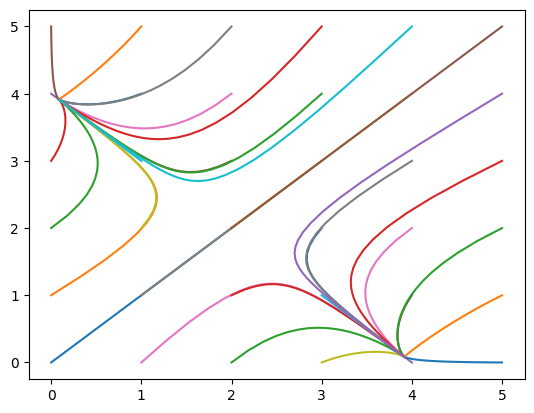

In [ ]:
ODE_dim = 2
Gamma = np.array([-1., -1.])
integration_time = 1
Win = np.array([[0, -1.], [-1., 0]])
Wout = np.array([[2., 0], [0, 2.]])
bin = np.array([[2.], [2.]])
bout = np.array([[2.], [2.]])

train_data, test_data = weights_to_dataset(integration_time, Gamma, Win=Win, bin=bin, Wout=Wout, bout=bout, batch_size = 10)

true_model = make_nODE_from_parameters(Gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)

true_model.phase_portrait(gridpoints=5, time_interval=[0.,10.])